## Data assimilation

### Initial assimilation - noisy baseline model to model

In [3]:
from Models import baseline_model, RibbySimplifiedOdeModel, baseline_simple_model, simplified_baseline_hyperparams, initial_tuple_simple, initial_tuple_ribba, baseline_hyperparams, surrogate_hyperparams, surrogate_model, RibbyOdeModel, Model
from Assimilation import compute_assimilated_parameters, simple_less_params_trainer, to_params_simple, ribba_model_trainer, to_params
from utils import compare_simple_model_results, plot_simple_model_results
import numpy as np
from Therapy import predefined_strategy, Therapy

In [4]:
def transform_results_to_simple(results):
  return {
  'P': results['P'] + results['Q'] + results['Qp'],
  'C': results['C']
}

In [53]:
def params_to_model_ribba(params):
  return RibbyOdeModel(to_params(params))

def params_to_model_simple(params):
  return RibbySimplifiedOdeModel(to_params_simple(params))

def get_assimilation(model, days, hyperparams, trainer, params_to_model, y0, bounds, transform, with_original_therapy = False):
  time_range = np.linspace(0, 101, 101)
  baseline_model.compute(initial_tuple_ribba, time_range)
  baseline_results = transform_results_to_simple(baseline_model.result)

  day_measurements_results = {key:value[days] for key,value in baseline_results.items()}
  assimilated_hyperparams = compute_assimilated_parameters(trainer, day_measurements_results, hyperparams, days)
  assimilated_model: Model = params_to_model(assimilated_hyperparams)
  assimilated_model.compute(y0, time_range)

  model.compute(y0, time_range)
  pre_assimilation_results = transform(model.result)
  assimilation_results = transform(assimilated_model.result)

  scatter_points = {key:[(day, value[day]) for day in days] for key,value in baseline_results.items()}

  compare_simple_model_results([baseline_results, assimilation_results, pre_assimilation_results], 
    time_range,
    ['baseline', 'assimilated', 'original'],
    scatter_points,
    lines=[days[0], days[-1]])

  therapy_results = []
  time_range = np.linspace(0, 131, 131)
  therapy = Therapy(baseline_model, predefined_strategy)
  therapy.compute_therapy(time_range, initial_tuple_ribba)
  therapy_results.append(transform_results_to_simple(therapy.results))

  therapy = Therapy(assimilated_model, predefined_strategy)
  therapy.compute_therapy(time_range, y0)
  therapy_results.append(transform(therapy.results))
  
  if(with_original_therapy):
    therapy = Therapy(model, predefined_strategy)
    therapy.compute_therapy(time_range, y0)
    therapy_results.append(transform(therapy.results))

  cells_baseline = therapy_results[0]['P']
  cells_assimilated = therapy_results[1]['P']

  error = sum([abs(x - y) for x,y in zip(cells_baseline, cells_assimilated)])
  
  compare_simple_model_results(therapy_results, 
    time_range,
    ['baseline', 'assimilated', 'original'])

  return [x for x in assimilated_hyperparams], error
    


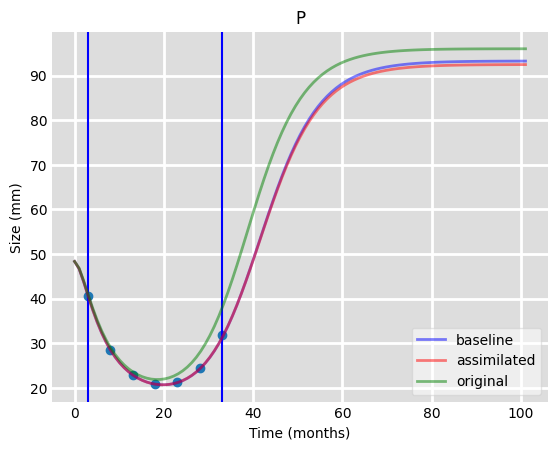

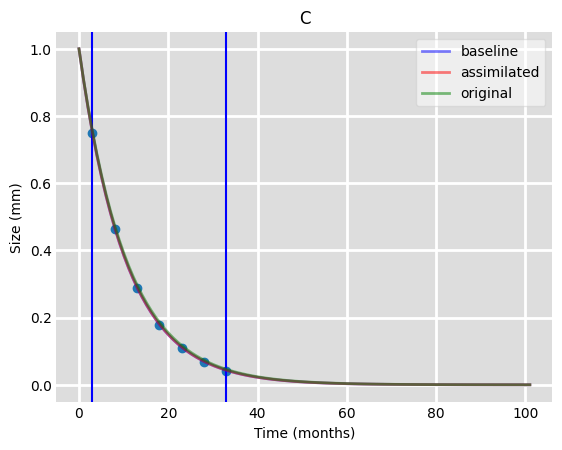

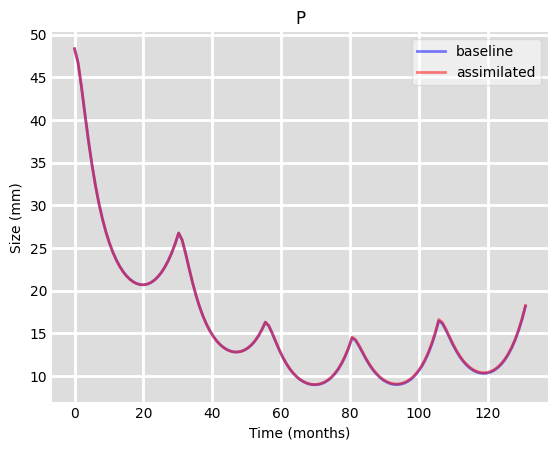

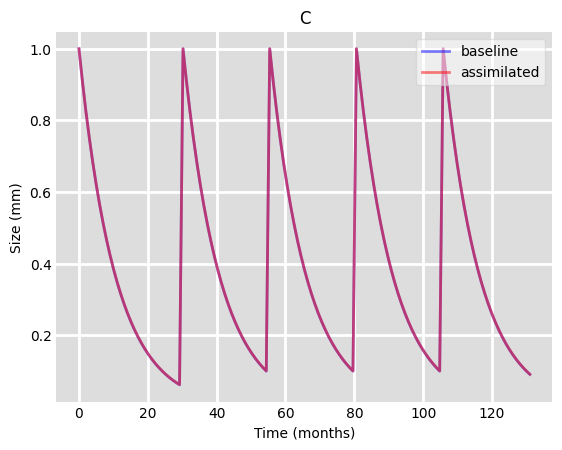

([0.6873443174508476,
  0.4239770078694458,
  0.00017113342489604867,
  0.6849038806948345,
  5.7409393112799965,
  1.3500547609978923,
  0.09493734925669939,
  160.14082773552337],
 6.280540104653134)

In [54]:
get_assimilation(
  surrogate_model,
  list(range(3,35,5)),
  surrogate_hyperparams,
  ribba_model_trainer,
  params_to_model_ribba,
  initial_tuple_ribba,
  None,
  transform_results_to_simple)

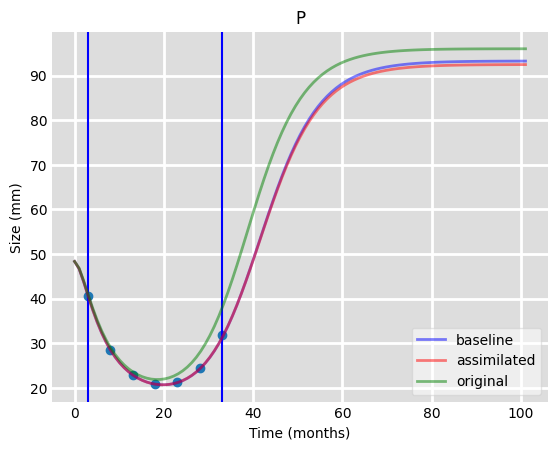

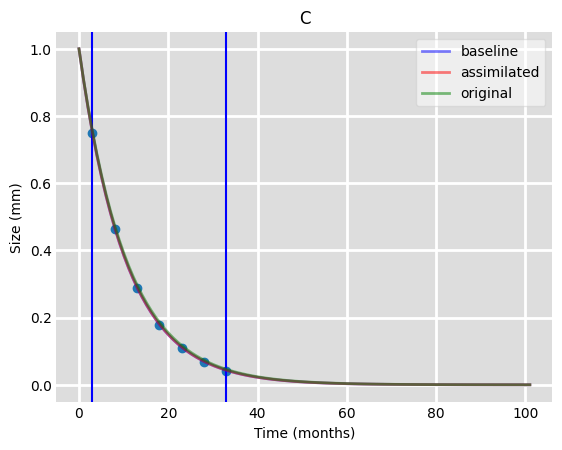

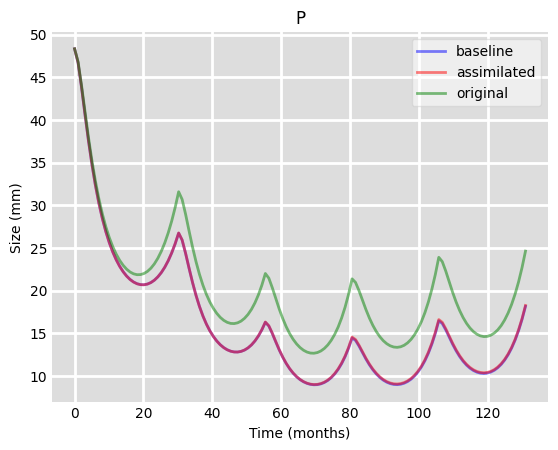

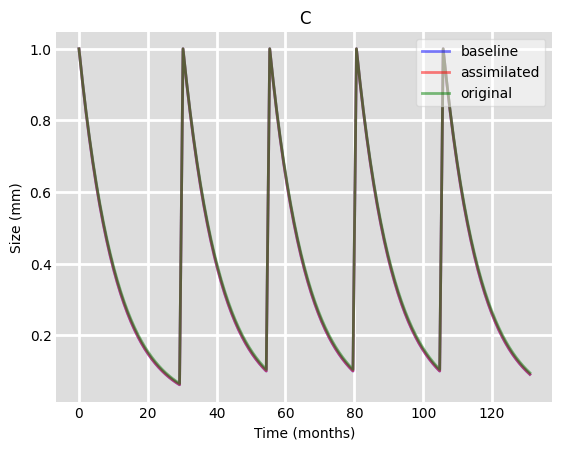

(array([6.87344317e-01, 4.23977008e-01, 1.71133425e-04, 6.84903881e-01,
        5.74093931e+00, 1.35005476e+00, 9.49373493e-02, 1.60140828e+02]),
 6.280540104653134)

In [9]:
get_assimilation(
  surrogate_model,
  list(range(3,35,5)),
  surrogate_hyperparams,
  ribba_model_trainer,
  params_to_model_ribba,
  initial_tuple_ribba,
  None,
  transform_results_to_simple,
  True)

### Assimilation - simple model to baseline model

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.6640690267556D+02   r2 =  0.3516931091023D-09
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.6636685152512D+02   r2 =  0.1713261277192D-09


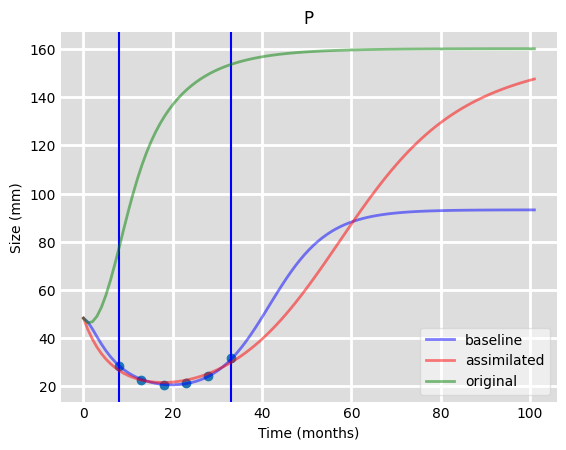

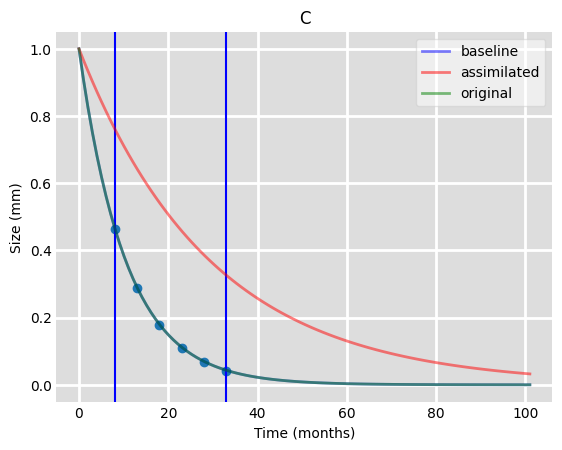

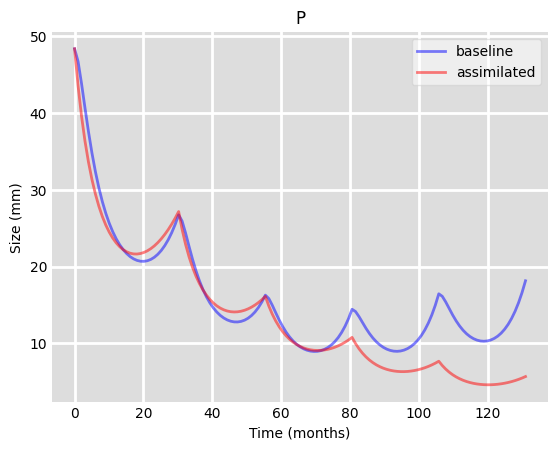

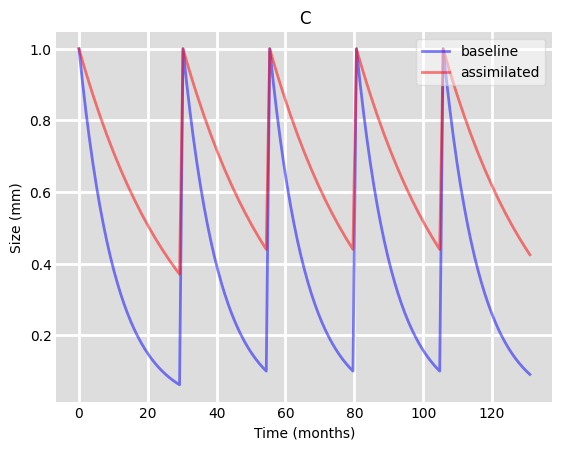

([0.123749712617196,
  5.767671811254381,
  0.03395246624804446,
  160.1323765421637],
 372.2912599294502)

In [60]:
get_assimilation(
  baseline_simple_model,
  list(range(8,35,5)),
  simplified_baseline_hyperparams,
  simple_less_params_trainer,
  params_to_model_simple,
  initial_tuple_simple,
  [None, None ,[0.05, 0.15], None],
  lambda x: x)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.6640690267556D+02   r2 =  0.3516931091023D-09
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.6636685152512D+02   r2 =  0.1713261277192D-09


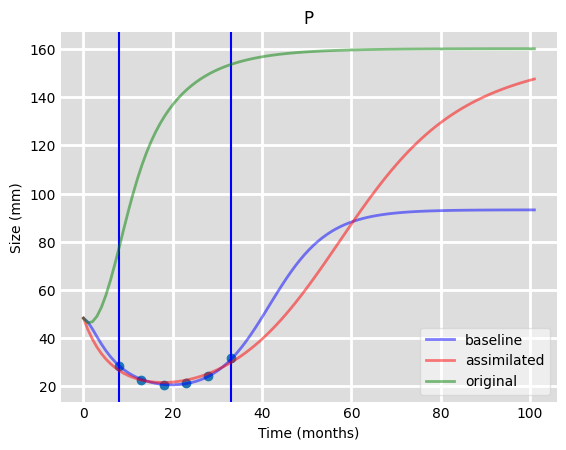

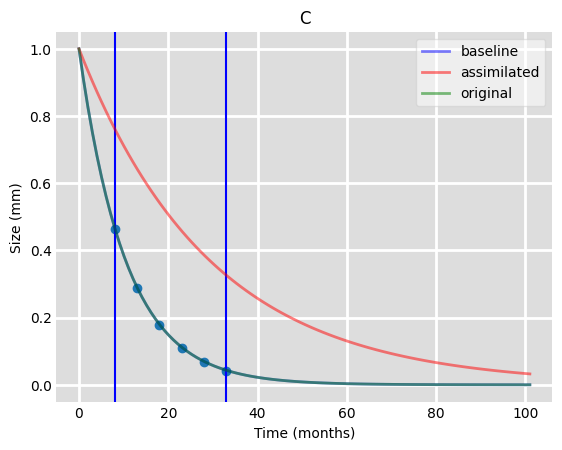

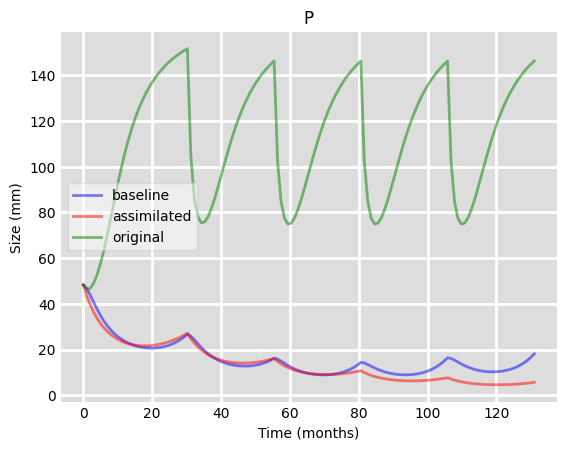

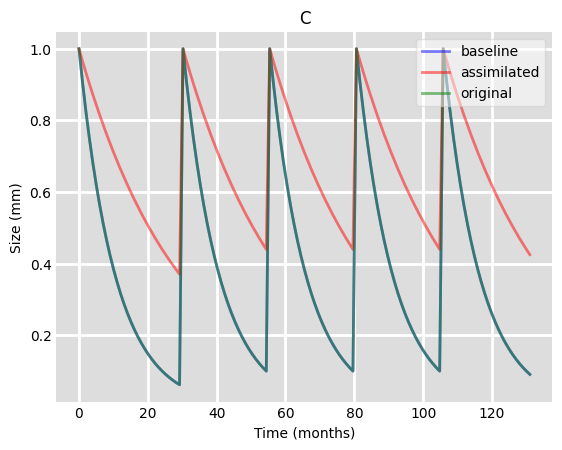

(array([1.23749713e-01, 5.76767181e+00, 3.39524662e-02, 1.60132377e+02]),
 372.2912599294502)

In [11]:
get_assimilation(
  baseline_simple_model,
  list(range(8,35,5)),
  simplified_baseline_hyperparams,
  simple_less_params_trainer,
  params_to_model_simple,
  initial_tuple_simple,
  [None, None ,[0.05, 0.15], None],
  lambda x: x,
  True
  )


### Assimilation - simple model with different assimilation settings

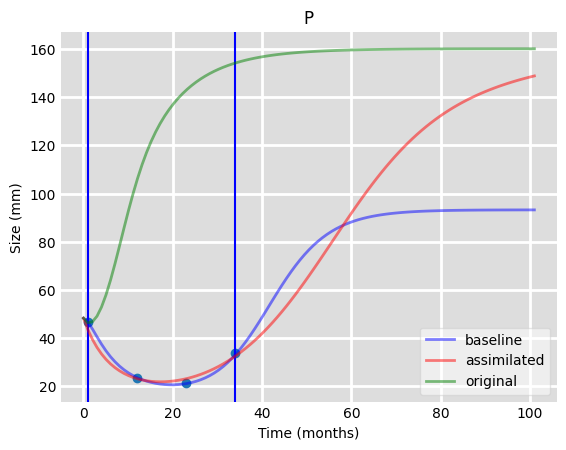

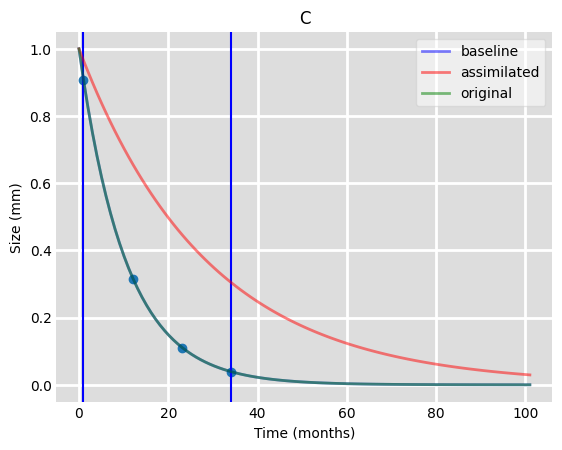

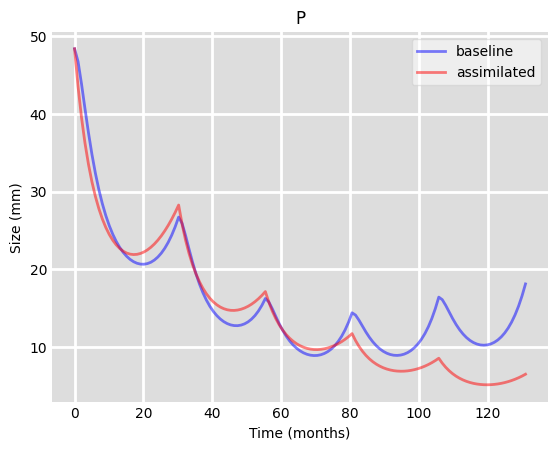

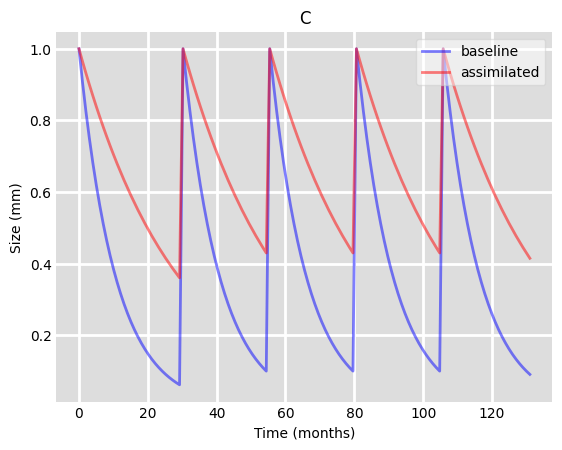

([0.12619229200992974,
  5.700571069209386,
  0.03489287094907352,
  160.12349441127665],
 353.2862550335943)

In [61]:
get_assimilation(
  baseline_simple_model,
  list(range(1,35,11)),
  simplified_baseline_hyperparams,
  simple_less_params_trainer,
  params_to_model_simple,
  initial_tuple_simple,
  [None, None ,[0.05, 0.15], None],
  lambda x: x)


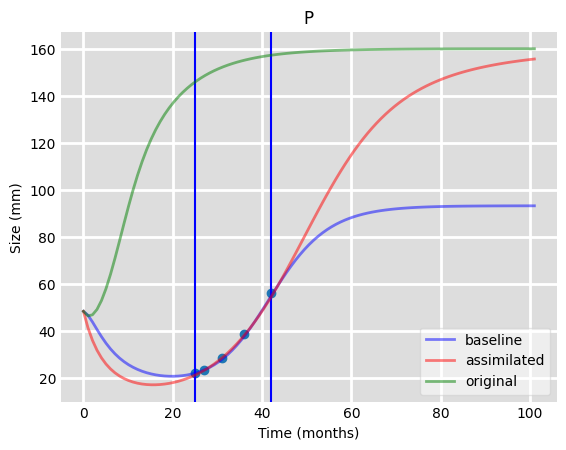

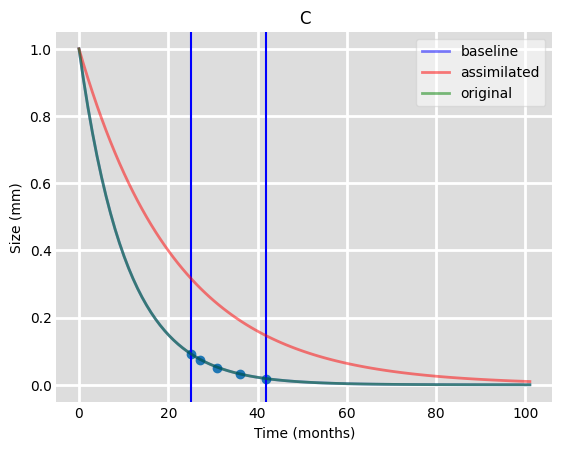

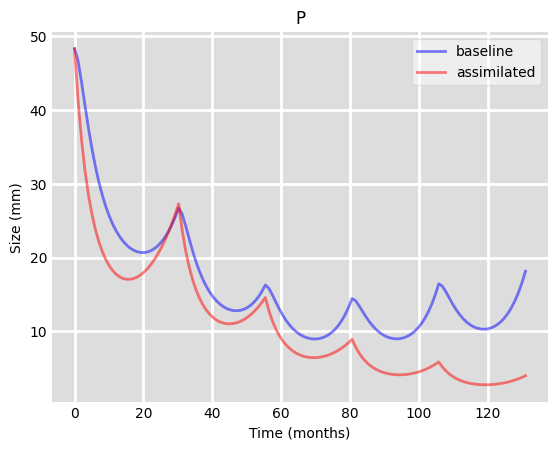

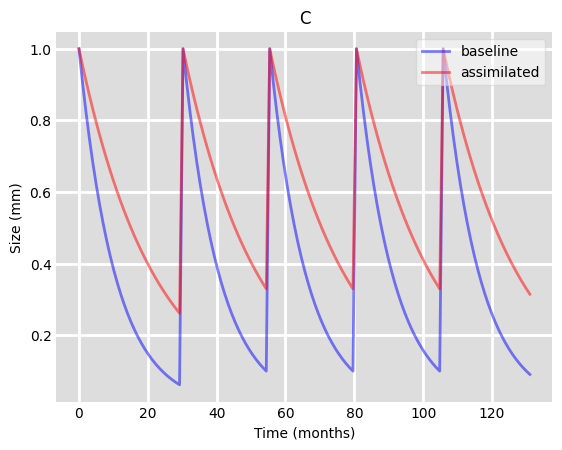

([0.14549913665879888,
  5.8012240977397465,
  0.04586515208938272,
  160.1264918912949],
 657.5478669462257)

In [62]:
get_assimilation(
  baseline_simple_model,
  list([25, 27, 31, 36, 42]),
  simplified_baseline_hyperparams,
  simple_less_params_trainer,
  params_to_model_simple,
  initial_tuple_simple,
  [None, None ,[0.05, 0.15], None],
  lambda x: x)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.5634564787825D+02   r2 =  0.1667499533800D-09


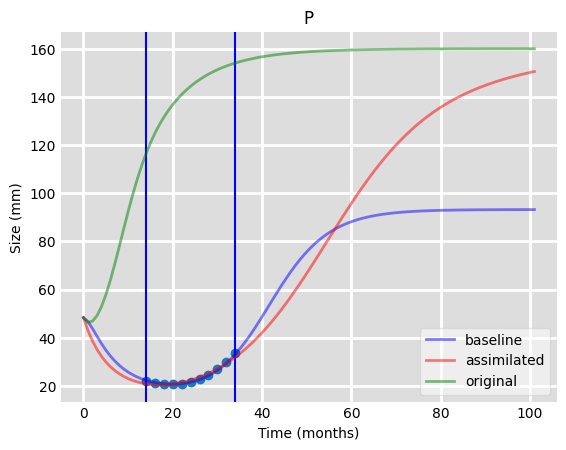

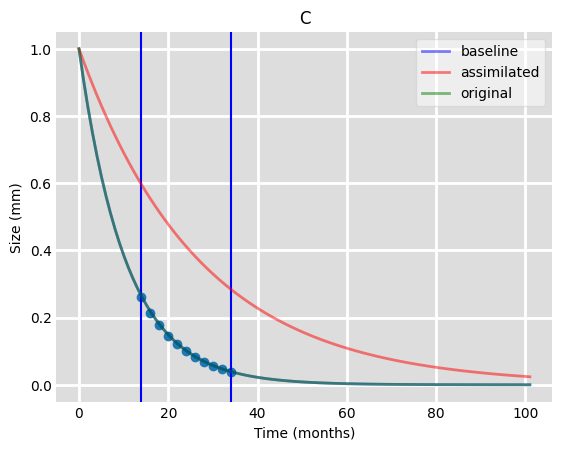

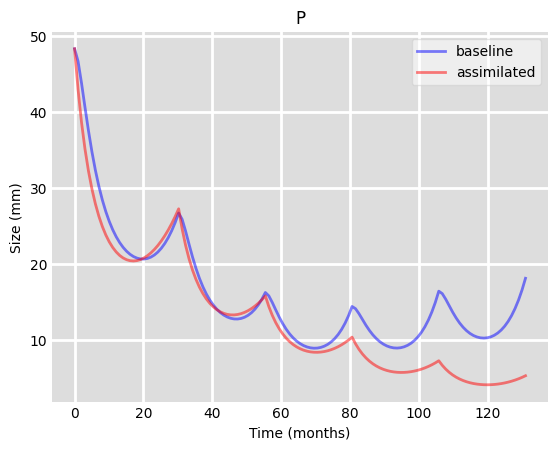

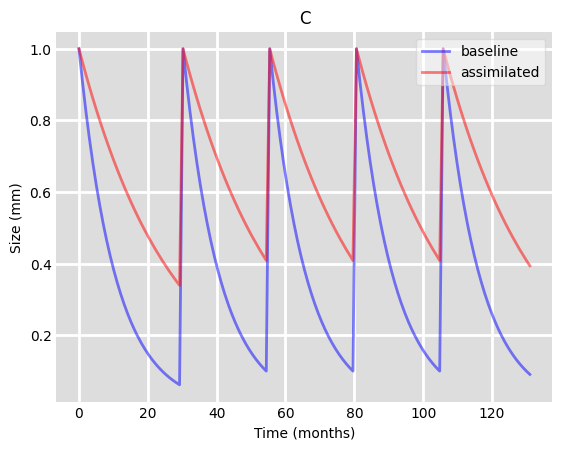

([0.13089808746672701,
  5.799668643323528,
  0.03695571196764159,
  160.12960102829993],
 419.22965814081203)

In [63]:
get_assimilation(
  baseline_simple_model,
  list(range(14,35,2)),
  simplified_baseline_hyperparams,
  simple_less_params_trainer,
  params_to_model_simple,
  initial_tuple_simple,
  [None, None ,[0.05, 0.15], None],
  lambda x: x)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.6861921227715D+02   r2 =  0.1373638439979D-10
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.6856030566896D+02   r2 =  0.2038902161619D-09


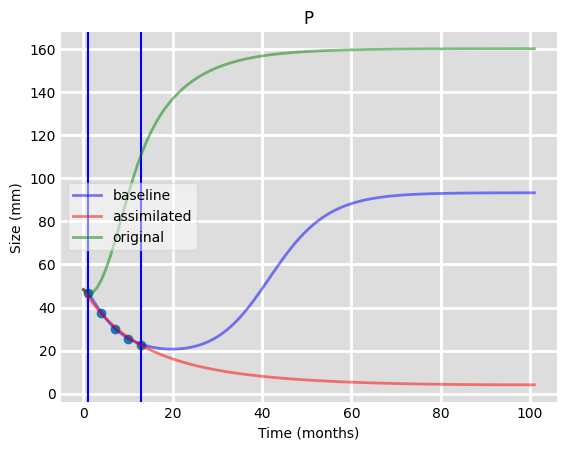

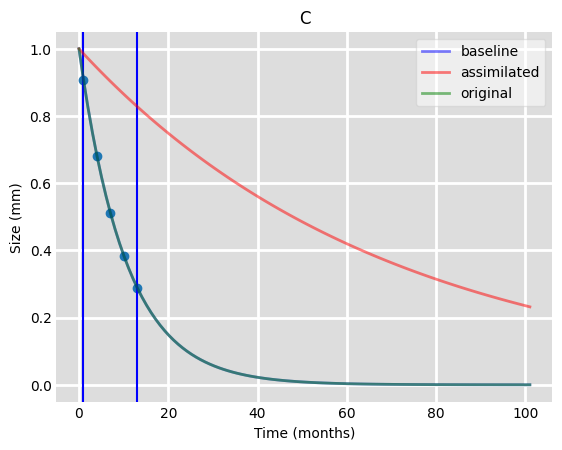

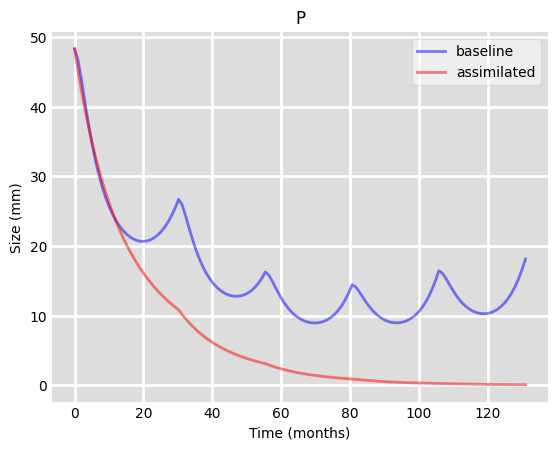

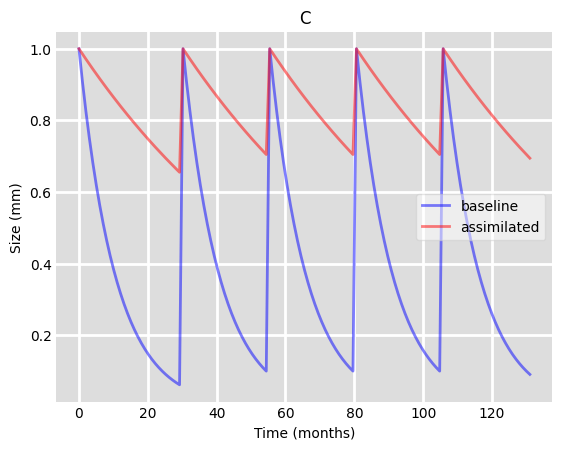

(array([2.04688198e-02, 5.71508346e+00, 1.44642596e-02, 1.60140584e+02]),
 1200.1914065038618)

In [35]:
get_assimilation(
  baseline_simple_model,
  list(range(1,16,3)),
  simplified_baseline_hyperparams,
  simple_less_params_trainer,
  params_to_model_simple,
  initial_tuple_simple,
  [None, None ,[0.05, 0.15], None],
  lambda x: x)


### Assimilation noisy model to baseline model

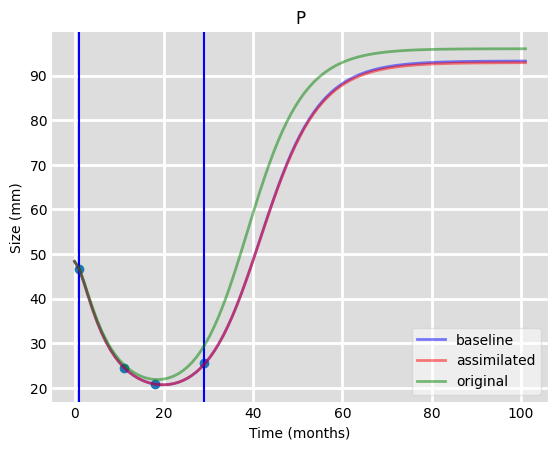

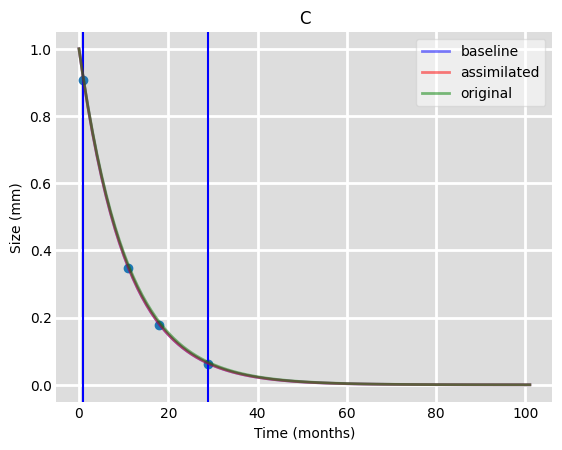

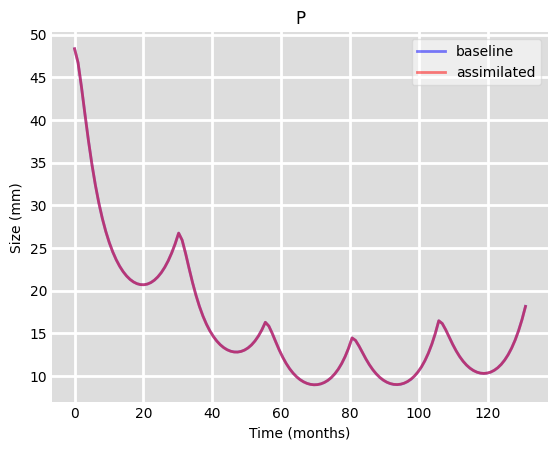

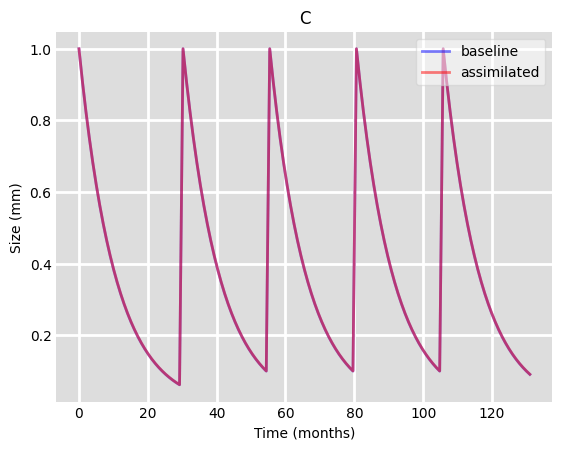

([0.6827564263760301,
  0.41994858678786856,
  0.0001565355104890487,
  0.682220546009444,
  5.742174490176373,
  1.346296386394094,
  0.09496812550980734,
  160.14081120090557],
 0.5951708078966469)

In [55]:
get_assimilation(
  surrogate_model,
  list([1,11,18,29]),
  surrogate_hyperparams,
  ribba_model_trainer,
  params_to_model_ribba,
  initial_tuple_ribba,
  None,
  transform_results_to_simple)

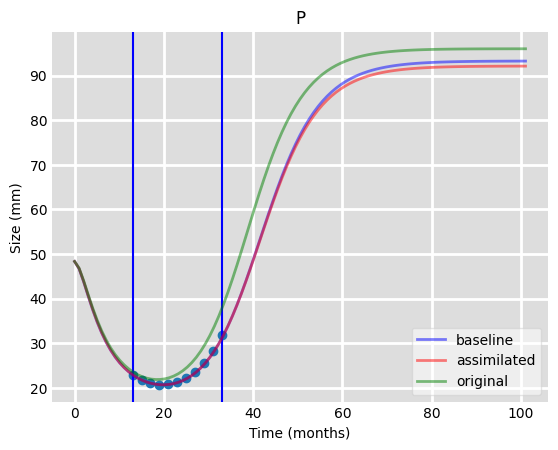

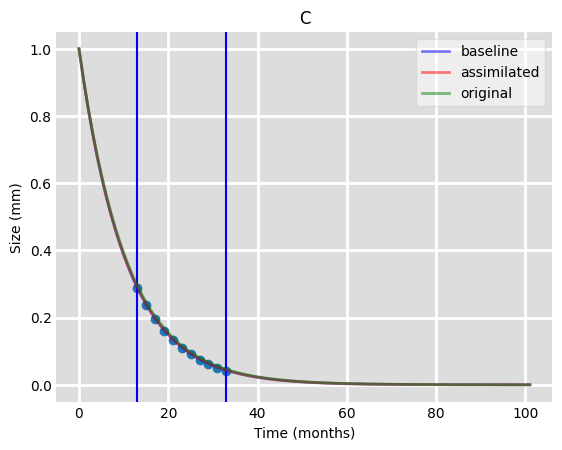

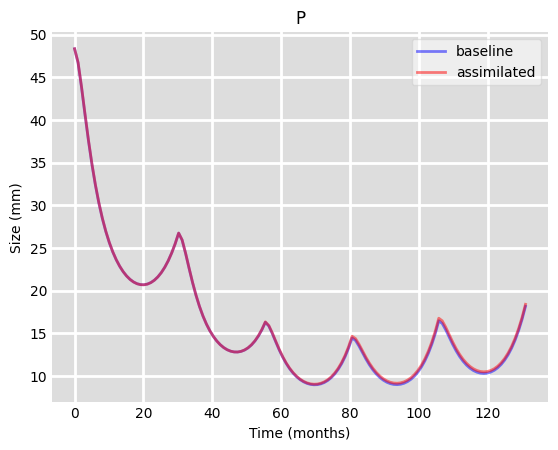

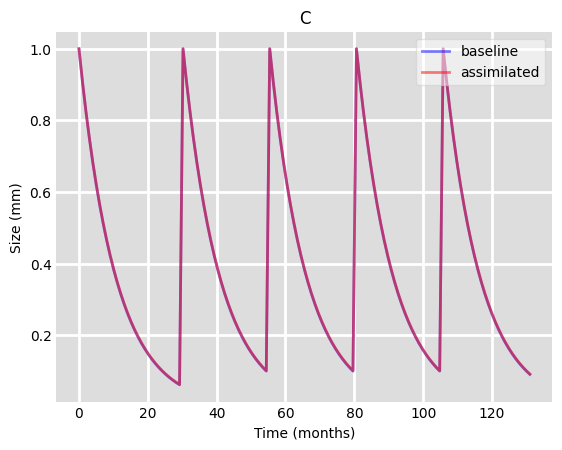

([0.6911414388242719,
  0.42721371000844993,
  9.728031978162375e-05,
  0.6788686858606587,
  5.740345730696879,
  1.3551361854972477,
  0.09464622084831582,
  160.1408322606558],
 13.779514924454048)

In [58]:
get_assimilation(
  surrogate_model,
  list(range(13, 35, 2)),
  surrogate_hyperparams,
  ribba_model_trainer,
  params_to_model_ribba,
  initial_tuple_ribba,
  None,
  transform_results_to_simple)

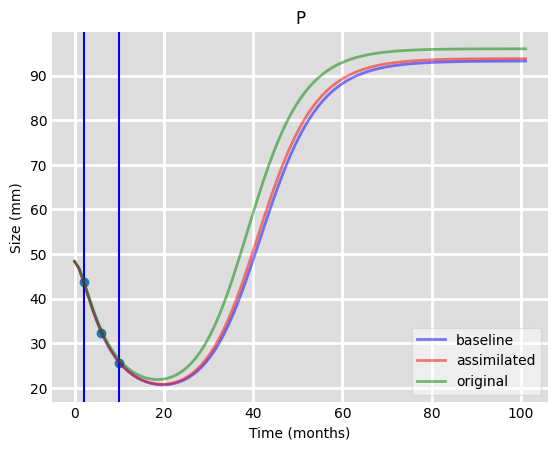

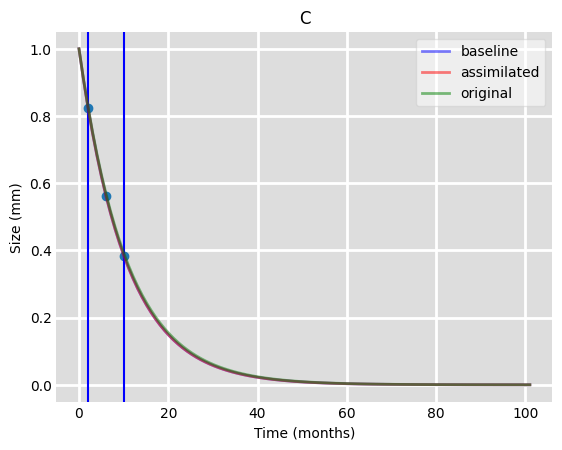

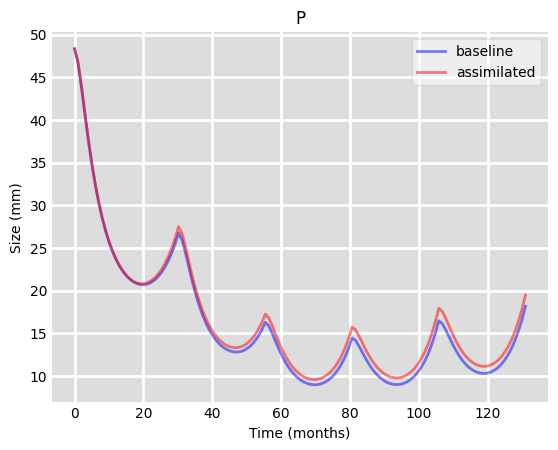

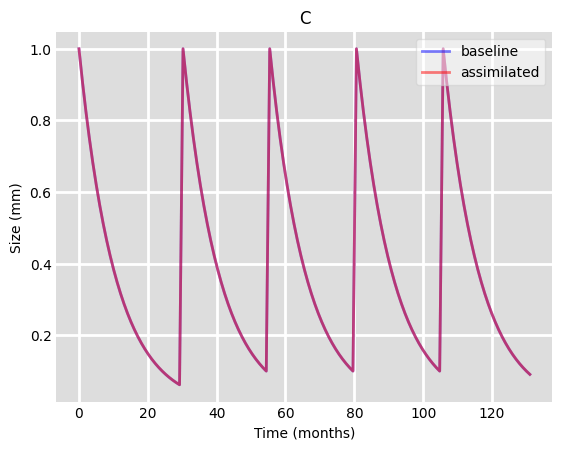

([0.6850957457520783,
  0.41827012405858416,
  -0.00011987765418715413,
  0.6805512656525039,
  5.742099080960018,
  1.3488730734725056,
  0.09508388969777284,
  160.14081181565908],
 89.09114576827339)

In [59]:
get_assimilation(
  surrogate_model,
  list(range(2, 12, 4)),
  surrogate_hyperparams,
  ribba_model_trainer,
  params_to_model_ribba,
  initial_tuple_ribba,
  None,
  transform_results_to_simple)